In [1]:
import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the ODE

$$\frac{du}{dt} - cos(2\pi t)=0$$

with solution 
$$ u(t) = \frac{sin ( 2 \pi t )}{2 \pi} + 1$$

## The Inverse parametric equation will be 

$$\frac{du}{dt} - cos( \alpha \pi t)=0$$

Text(0, 0.5, 'Observations')

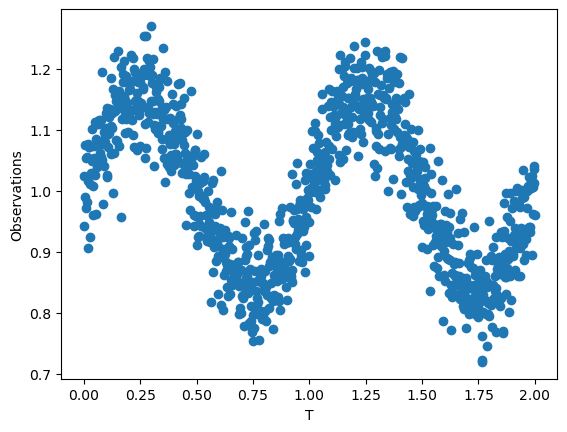

In [2]:
t= np.linspace(0,2,1000)
mean, std = 0,0.05

Exact = (1/ (2*np.pi))*np.sin(2*np.pi*t)+1

noise_sol = Exact + np.random.normal(mean,std, len(t))

plt.scatter(t,noise_sol)
plt.xlabel("T")
plt.ylabel("Observations")


## Feed Forward Neural Network

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

## PINN for Inverse Problems

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self,training_data, alpha, layers):
        
        # deep neural networks
        self.layers = layers
        self.dnn = DNN(layers).to(device)

        # Parameter to estimate
        self.alpha = torch.nn.Parameter(torch.tensor(alpha, requires_grad=True).float().to(device))

        self.dnn.register_parameter("alpha", self.alpha)

        self.loss_function = torch.nn.MSELoss(reduction ='mean')
        
        self.training_data = torch.tensor(training_data, requires_grad=True).float().to(device)
        
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=0.1, 
            max_iter=50000,
            max_eval=None, 
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

     
        self.iter = 0

    def parameters (self):
        return self.dnn.parameters()
        
    def net_u(self,t): 
        u = self.dnn(t)
        return u
    
    def net_f(self,t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t - self.alpha*torch.cos( 2*torch.pi *t)
        return f
    
    def losses(self):

        t = self.training_data[:,0:1] 
        Y_obs = self.training_data[:,1:] 

        f_pred = self.net_f(t)
        u_pred = self.net_u(t)

        loss_u = self.loss_function(Y_obs,u_pred)
        loss_f = self.loss_function(f_pred,torch.zeros_like(Y_obs))

        return loss_u,loss_f

    
    def loss_func_train(self):

        self.optimizer.zero_grad()
        loss_u, loss_f = self.losses()
        
        loss = loss_u + loss_f

        loss.backward() 

        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e, Alpha:%.3f' % (self.iter, loss.item(), loss_u.item(), loss_f.item(),self.alpha.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func_train)

            
    def predict(self, t):
        #t = torch.tensor(X, requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(t)
        f = self.net_f(t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [5]:
# Number of observations
nobs = 500

layers = [1]+2*[10] +[1]

data_training = np.hstack((t.flatten()[:,None], noise_sol.flatten()[:,None]))

idx = np.random.choice(data_training.shape[0], nobs, replace=False)

X_u_train = data_training[idx, :]

In [6]:
model = PhysicsInformedNN(X_u_train, 0.2,layers)

In [7]:
model.train()

Iter 100, Loss: 1.38516e-02, Loss_u: 1.33303e-02, Loss_f: 5.21312e-04, Alpha:0.012
Iter 200, Loss: 1.12541e-02, Loss_u: 9.73486e-03, Loss_f: 1.51925e-03, Alpha:0.190
Iter 300, Loss: 3.18671e-03, Loss_u: 2.46939e-03, Loss_f: 7.17325e-04, Alpha:0.881
Iter 400, Loss: 2.50728e-03, Loss_u: 2.31623e-03, Loss_f: 1.91051e-04, Alpha:0.976
Iter 500, Loss: 2.44009e-03, Loss_u: 2.31313e-03, Loss_f: 1.26961e-04, Alpha:0.980
Iter 600, Loss: 2.34184e-03, Loss_u: 2.31245e-03, Loss_f: 2.93901e-05, Alpha:0.995
Iter 700, Loss: 2.33254e-03, Loss_u: 2.31257e-03, Loss_f: 1.99733e-05, Alpha:0.990
Iter 800, Loss: 2.32042e-03, Loss_u: 2.31314e-03, Loss_f: 7.27580e-06, Alpha:0.992
Iter 900, Loss: 2.31896e-03, Loss_u: 2.31326e-03, Loss_f: 5.69864e-06, Alpha:0.993


In [8]:
import os
os.chdir("..")
os.getcwd()

'/home/s2113174/Projects-1'

In [9]:
from LaplacePINN.laplace import Laplace


la = Laplace(model, 'regression',subset_of_weights='last_layer', hessian_structure='diag')

In [10]:
from torch.nn.utils import parameters_to_vector, vector_to_parameters


training_data = torch.tensor(X_u_train, requires_grad=True).float().to(device)

la.model.eval()

if la.model.last_layer is None:
    X, _ = training_data[:,0:1], training_data[:,1:] 
    with torch.no_grad():
        try:
            la.model.find_last_layer(X.to(device))
            #self.model.find_last_layer(X[:1].to(self._device))
        except (TypeError, AttributeError):
            la.model.find_last_layer(X.to(device))
    params = parameters_to_vector(la.model.last_layer.parameters()).detach()
    params = torch.cat((params , torch.tensor([model.dnn.get_parameter("alpha").detach()])))

    n_params = len(params)
    n_layers = len(list(la.model.last_layer.parameters()))+1
    # here, check the already set prior precision again
    la.prior_precision = 1
    la.prior_mean = 0
        

In [ ]:
act_out = dict()
def get_act_hook(name):
    def act_hook(_, input, __):
        # only accepts one input (expects linear layer)
        try:
            act_out[name] = input[0].detach()
        except (IndexError, AttributeError):
            act_out[name] = None
        # remove hook
        handles[name].remove()
    return act_hook

In [32]:
act_out = dict()
def get_act_hook(name):
    def act_hook(_, input, __):
        # only accepts one input (expects linear layer)
        try:
            act_out[name] = input[0].detach()
        except (IndexError, AttributeError):
            act_out[name] = None
        # remove hook
        handles[name].remove()
    return act_hook

In [33]:
handles = dict()
for name, module in model.dnn.named_modules():
            handles[name] = module.register_forward_hook(get_act_hook(name))

In [11]:
from backpack import backpack, extend, memory_cleanup
from backpack.extensions import DiagGGNExact, DiagGGNMC, KFAC, KFLR, SumGradSquared, BatchGrad
from backpack.context import CTX

In [40]:
def _get_diag_ggn(model,stochastic):
    if stochastic:
        return torch.cat([p.diag_ggn_mc.data.flatten() for p in la.model.last_layer.parameters()])
    else:
        return torch.cat([p.diag_ggn_exact.data.flatten() for p in model.dnn.parameters()])

In [43]:
stochastic = False
loss_function = torch.nn.MSELoss(reduction ='mean')

context = DiagGGNMC if stochastic else DiagGGNExact

model_ = extend(model.dnn)

X, y = next(iter(training_data))

X,y = X.reshape((1)), y.reshape((1)) 

u = model_.net_u(X)
f = model_.net_f(X)
yhat = torch.zeros_like(y)

loss = loss_function(u,y) + loss_function(f,yhat)

with backpack(context()):
   loss.backward()
dggn = _get_diag_ggn(model_,stochastic)

AttributeError: 'DNN' object has no attribute 'net_u'

In [ ]:
def diag(model, X_training, stochastic):
    context = DiagGGNMC if stochastic else DiagGGNExact
    f = model.eval(X_training)
    loss = model.
    with backpack(context()):
        loss.backward()
    dggn = self._get_diag_ggn()

In [15]:
def _init_H(n_params):
        return torch.zeros(n_params, device=device)

In [ ]:
def log_marginal_likelihood(self, prior_precision=None, sigma_noise=None):
    """Compute the Laplace approximation to the log marginal likelihood subject
    to specific Hessian approximations that subclasses implement.
    Requires that the Laplace approximation has been fit before.
    The resulting torch.Tensor is differentiable in `prior_precision` and
    `sigma_noise` if these have gradients enabled.
    By passing `prior_precision` or `sigma_noise`, the current value is
    overwritten. This is useful for iterating on the log marginal likelihood.

    Parameters
    ----------
    prior_precision : torch.Tensor, optional
        prior precision if should be changed from current `prior_precision` value
    sigma_noise : [type], optional
        observation noise standard deviation if should be changed

    Returns
    -------
    log_marglik : torch.Tensor
    """
    # update prior precision (useful when iterating on marglik)
    if prior_precision is not None:
        self.prior_precision = prior_precision

    # update sigma_noise (useful when iterating on marglik)
    if sigma_noise is not None:
        if self.likelihood != 'regression':
            raise ValueError('Can only change sigma_noise for regression.')
        self.sigma_noise = sigma_noise

    return self.log_likelihood - 0.5 * (self.log_det_ratio + self.scatter)

In [ ]:
@property
def scatter(self):
    """Computes the _scatter_, a term of the log marginal likelihood that
    corresponds to L-2 regularization:
    `scatter` = \\((\\theta_{MAP} - \\mu_0)^{T} P_0 (\\theta_{MAP} - \\mu_0) \\).

    Returns
    -------
    [type]
        [description]
    """
    delta = (self.mean - self.prior_mean)
    return (delta * self.prior_precision_diag) @ delta

In [ ]:
@property
def log_det_ratio(self):
    """Compute the log determinant ratio, a part of the log marginal likelihood.
    \\[
        \\log \\frac{\\det P}{\\det P_0} = \\log \\det P - \\log \\det P_0
    \\]

    Returns
    -------
    log_det_ratio : torch.Tensor
    """
    return self.log_det_posterior_precision - self.log_det_prior_precision

In [ ]:
@property
def log_det_prior_precision(self):
    """Compute log determinant of the prior precision
    \\(\\log \\det P_0\\)

    Returns
    -------
    log_det : torch.Tensor
    """
    return self.prior_precision_diag.log().sum()

In [ ]:
@property
def log_det_posterior_precision(self):
    return self.posterior_precision.log().sum()

In [ ]:
@property
def posterior_precision(self):
    """Diagonal posterior precision \\(p\\).

    Returns
    -------
    precision : torch.tensor
        `(parameters)`
    """
    self._check_H_init()
    return self._H_factor * self.H + self.prior_precision_diag

In [11]:
la.fit(torch.tensor(X_u_train, requires_grad=True).float().to(device))

In [ ]:
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)

hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

for i in range(1000):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()

In [14]:
la.n_layers

In [13]:
parameters_to_vector(la.model.last_layer.parameters()).detach()

tensor([-0.8511, -0.8350, -0.4593,  0.2588,  2.0157, -1.5183,  2.1094,  4.1278,
        -2.6083, -0.2535,  0.4257])

In [434]:
t= np.linspace(0,3,500)

sol = (1/ (2*np.pi))*np.sin(2*np.pi*t)+1

noise_sol_test = sol + np.random.normal(mean,std, len(t))

In [435]:
u_pred, f_pred = model.predict(t.flatten()[:,None] )

error_u = np.linalg.norm(noise_sol_test-u_pred,2)/np.linalg.norm(noise_sol_test,2)
print('Error u: %e' % (error_u))  

Error u: 5.438582e+00


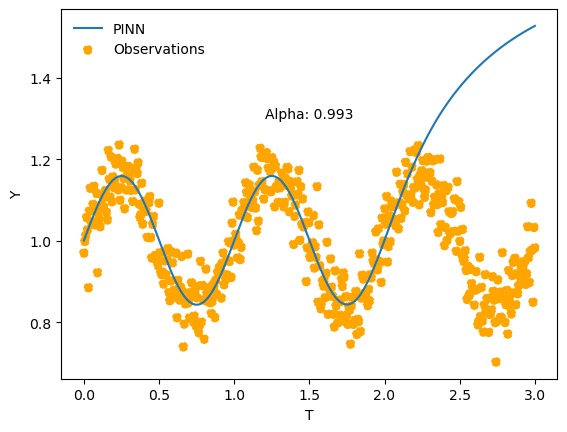

In [436]:
plt.plot(t, u_pred, label = "PINN")
plt.scatter(t,noise_sol_test,linestyle='dashed', label = "Observations",color= "orange")

plt.annotate(f"Alpha: {model.alpha.item():0.3f}",(1.5,1.3),ha='center')

plt.xlabel("T")
plt.ylabel("Y")
plt.legend(frameon=False)

In [16]:
import os
os.chdir("..")
os.getcwd()

'/home/s2113174'

In [17]:
from LaplacePINN.laplace import Laplace


la = Laplace(model, 'regression',
                subset_of_weights='last_layer',
                hessian_structure='diag')

In [18]:
la.model.find_last_layer(torch.tensor(t.flatten()[:,None], requires_grad=True).float().to(device))

tensor([[0.9997],
        [1.0019],
        [1.0041],
        [1.0063],
        [1.0085],
        [1.0106],
        [1.0127],
        [1.0148],
        [1.0169],
        [1.0189],
        [1.0209],
        [1.0230],
        [1.0249],
        [1.0269],
        [1.0289],
        [1.0308],
        [1.0327],
        [1.0346],
        [1.0365],
        [1.0384],
        [1.0402],
        [1.0421],
        [1.0439],
        [1.0457],
        [1.0475],
        [1.0493],
        [1.0511],
        [1.0529],
        [1.0546],
        [1.0564],
        [1.0581],
        [1.0599],
        [1.0616],
        [1.0633],
        [1.0650],
        [1.0667],
        [1.0684],
        [1.0701],
        [1.0718],
        [1.0735],
        [1.0751],
        [1.0768],
        [1.0784],
        [1.0801],
        [1.0817],
        [1.0834],
        [1.0850],
        [1.0866],
        [1.0882],
        [1.0898],
        [1.0914],
        [1.0930],
        [1.0946],
        [1.0962],
        [1.0978],
        [1

In [19]:
la.fit(torch.tensor(t.flatten()[:,None], requires_grad=True).float().to(device))


TypeError: zeros() received an invalid combination of arguments - got (NoneType, device=torch.device), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [20]:
from torch.nn.utils import parameters_to_vector, vector_to_parameters
la.model.last_layer




Linear(in_features=20, out_features=1, bias=True)

In [8]:
import os
#os.chdir("..")
os.getcwd()

'/home/s2113174/Projects-1/Physics _Informed_NN'

In [51]:
from laplace.utils import FeatureExtractor 
from copy import deepcopy

FeatureExtractor(model, last_layer_name=None)

FeatureExtractor()

In [10]:
u_pred, f_pred = model.predict(t.flatten()[:,None] )

error_u = np.linalg.norm(Exact-u_pred,2)/np.linalg.norm(Exact,2)
print('Error u: %e' % (error_u))                     

Error u: 1.166517e+01


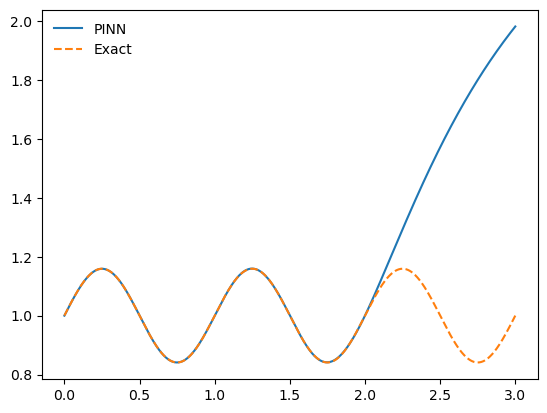

In [11]:
plt.plot(t, u_pred, label = "PINN")
plt.plot(t,Exact,linestyle='dashed', label = "Exact")
plt.legend(frameon=False)